In [16]:
#allows imports from other folders in project
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# NBEATS MODEL

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/120, Train Loss: 32.89779, Valid Loss: 11.10052
Epoch 2/120, Train Loss: 1.41724, Valid Loss: 0.09208
Epoch 3/120, Train Loss: 0.33798, Valid Loss: 1.37659
Epoch 4/120, Train Loss: 0.15474, Valid Loss: 0.24670
Epoch 5/120, Train Loss: 0.05291, Valid Loss: 0.17074
Epoch 6/120, Train Loss: 0.01799, Valid Loss: 0.00292
Epoch 7/120, Train Loss: 0.00735, Valid Loss: 0.00492
Epoch 8/120, Train Loss: 0.00455, Valid Loss: 0.02901
Epoch 9/120, Train Loss: 0.00268, Valid Loss: 0.00158
Epoch 10/120, Train Loss: 0.00113, Valid Loss: 0.00255
Epoch 11/120, Train Loss: 0.00069, Valid Loss: 0.00479
Epoch 12/120, Train Loss: 0.00045, Valid Loss: 0.00020
Epoch 13/120, Train Loss: 0.00046, Valid Loss: 0.00244
Epoch 14/120, Train Loss: 0.00046, Valid Loss: 0.00177
Epoch 15/120, Train Loss: 0.00041, Valid Loss: 0.00007
Epoch 16/120, Train Loss: 0.00047, Valid Loss: 0.00024
Epoch 17/120, Train Loss: 0.00035, Valid Loss: 0.00297
Epoch 18/120, Train Loss: 0.00039, Valid Loss: 0.00020
Epoch 19/120, Tra

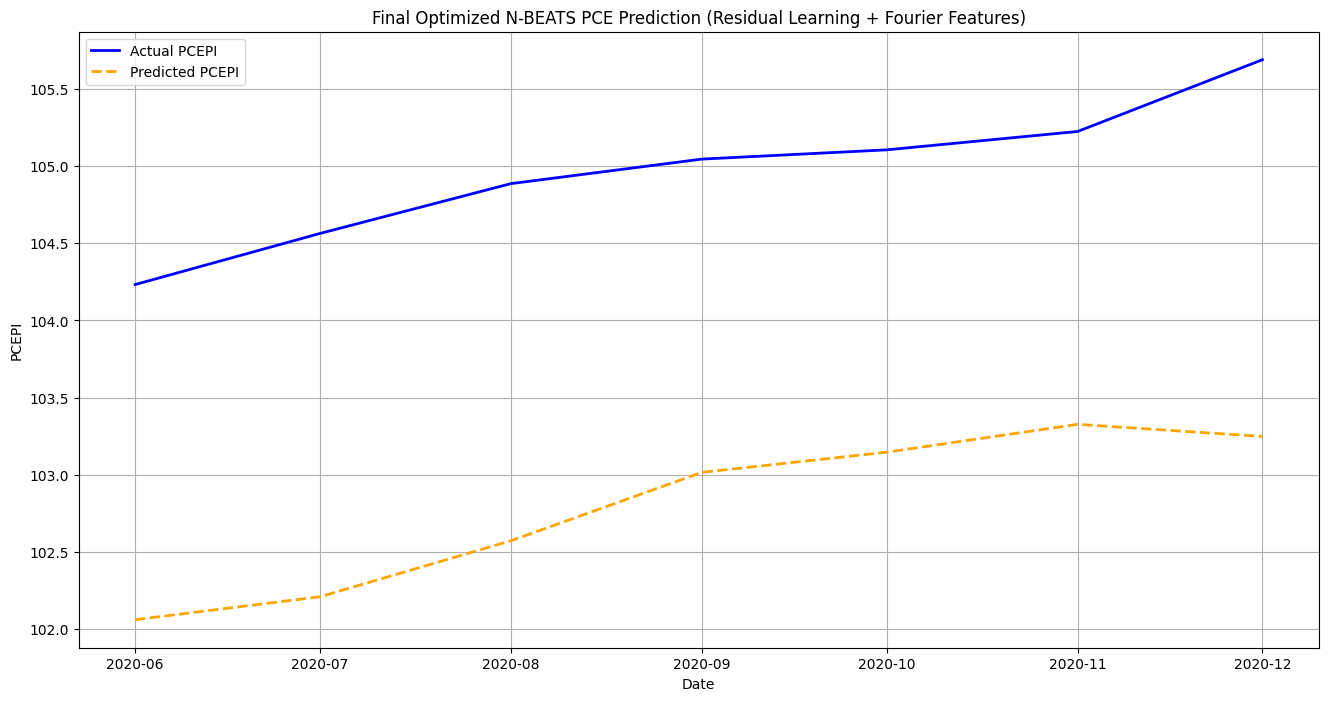

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from Models.NBEATS import NBeats
from dataPreprocessing import load_data, prepare_dataloader


# Load Data and Create Model
train_file = "../Data/Train/train1990s.csv"
config = {
    "use_fft": False,  # No FFT needed
    "use_exog": False  # No exogenous variables
}
X_train, y_train, X_valid, y_valid, X_test, y_test, dates, scaler, y_scaler = load_data(train_file, config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(input_size=X_train.shape[1]).to(device)

# Prepare DataLoaders
dataloader_train = prepare_dataloader(X_train, y_train)
dataloader_valid = prepare_dataloader(X_valid, y_valid)
dataloader_test = prepare_dataloader(X_test, y_test)

# Training Setup
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-7)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the Optimized N-BEATS Model with Early Stopping
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, scheduler, device, save_path='../Models/Weights/', max_epochs=120):
    model.train()
    best_valid_loss = float("inf")
    patience, patience_counter = 15, 0

    for epoch in range(max_epochs):
        train_loss, valid_loss = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                valid_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.5f}, Valid Loss: {avg_valid_loss:.5f}")

        # Pass validation loss to scheduler
        scheduler.step(avg_valid_loss)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), f"{save_path}/best_nbeats.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

train_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device, save_path='../Models/Weights/', max_epochs=120)

# Load Best Model and Evaluate on Test Set
model.load_state_dict(torch.load("../Models/Weights/best_nbeats.pth"))
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
predictions = model(X_test_tensor).detach().cpu().numpy()

# Convert Predictions Back to Original Scale
predictions = y_scaler.inverse_transform(predictions)
y_test_original = y_scaler.inverse_transform(y_test)

# Final Improved Graph
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(y_test_original):], y_test_original, label="Actual PCEPI", color="blue", linewidth=2)
plt.plot(dates[-len(predictions):], predictions, label="Predicted PCEPI", linestyle="dashed", color="orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.title("Final Optimized N-BEATS PCE Prediction (Residual Learning + Fourier Features)")
plt.legend()
plt.grid()
plt.show()


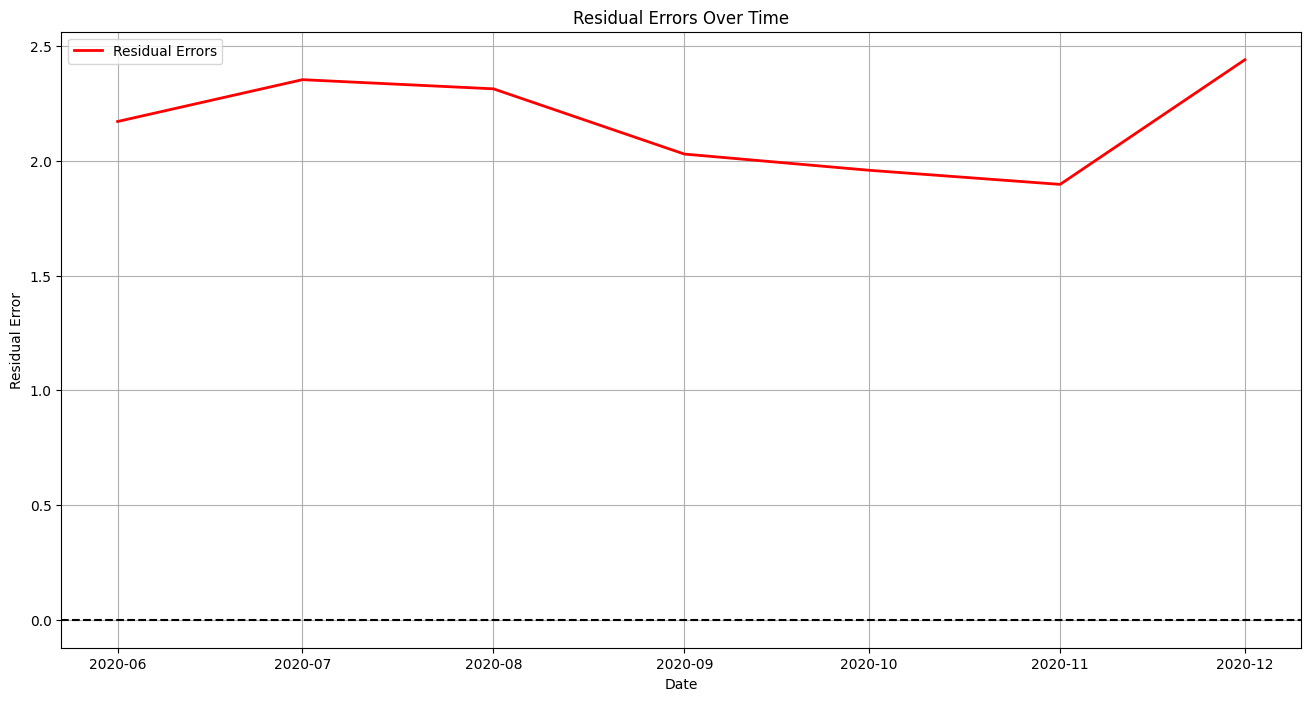

Mean Absolute Error (MAE): 2.16717
Root Mean Square Error (RMSE): 2.17593


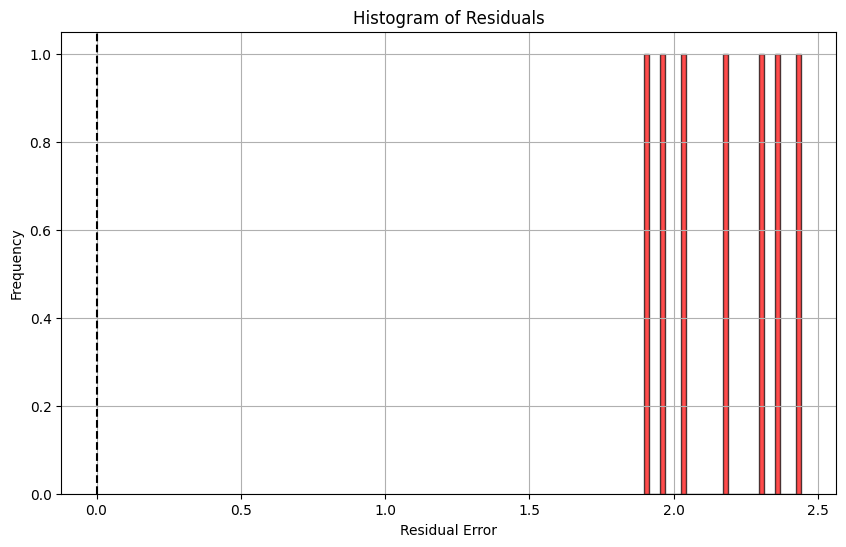

In [18]:
# Compute residual errors
residuals = y_test_original - predictions
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(residuals):], residuals, label="Residual Errors", color="red", linewidth=2)
plt.axhline(y=0, color='black', linestyle='dashed')  # Reference line at 0
plt.xlabel("Date")
plt.ylabel("Residual Error")
plt.title("Residual Errors Over Time")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE
mae = mean_absolute_error(y_test_original, predictions)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))

print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Square Error (RMSE): {rmse:.5f}")

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', color='red', alpha=0.7)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.axvline(x=0, color='black', linestyle='dashed')  # Reference line at 0
plt.grid()
plt.show()




In [ ]:
print(f"X_train shape: {X_train_tensor.shape}")
print(f"X_exog_train shape: {X_exog_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")


X_train shape: torch.Size([13872, 5])
X_exog_train shape: torch.Size([204, 357])
y_train shape: torch.Size([204, 1])
